# K-Means clustering을 위한 RFM 도출

# 데이터 로드

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings # 경고메세지 무시하기
warnings.filterwarnings(action='ignore')

<AxesSubplot:title={'center':'한글폰트'}>

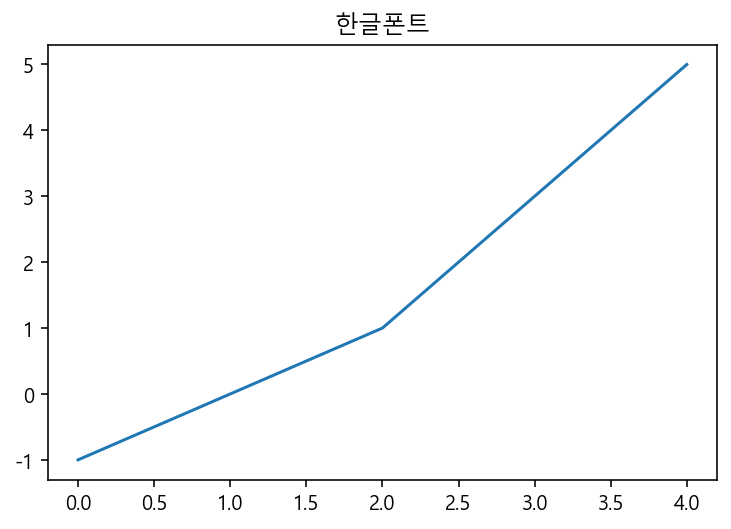

In [2]:
# 한글폰트

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False) #마이너스 코드 
pd.options.display.float_format = '{:.3f}'.format
from IPython.display import set_matplotlib_formats #폰트 선명하게 설정.
set_matplotlib_formats('retina') 
pd.Series([-1,0,1,3,5]).plot(title="한글폰트") # 한글폰트와 마이너스 폰트 설정 확인

In [3]:
# 데이터 로드

df = pd.read_csv('전처리완료최종데이터.csv', parse_dates=['구매일자'])
df.shape

(211076, 13)

In [4]:
df.isnull().sum()

ID      0
성별      0
연령대     0
시도      0
시군구     0
구매일자    0
구매시간    0
구매금액    0
구매수량    0
업종      0
소분류명    0
중분류명    0
대분류명    0
dtype: int64

In [5]:
df

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명
0,1,남성,60대,서울특별시,강동구,2015-05-13,12,6900,1,백화점,어묵,젓갈/반찬,식품
1,1,남성,60대,서울특별시,강동구,2015-05-13,12,2400,2,백화점,어묵,젓갈/반찬,식품
2,1,남성,60대,서울특별시,강동구,2015-11-04,18,3200,1,백화점,디저트류,차/커피,식품
3,1,남성,60대,서울특별시,강동구,2015-06-10,19,5000,1,백화점,"제과,제빵",가공식품,식품
4,1,남성,60대,서울특별시,강동구,2015-01-28,13,18000,2,백화점,식당가 한식,가공식품,식품
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211071,19952,남성,20대,서울특별시,광진구,2015-12-11,14,8700,1,백화점,스넥(부대),가공식품,식품
211072,19952,남성,20대,서울특별시,광진구,2015-12-18,16,3000,1,백화점,전문베이커리,가공식품,식품
211073,19952,남성,20대,서울특별시,광진구,2015-12-21,12,8500,1,백화점,식당가 한식,가공식품,식품
211074,19952,남성,20대,서울특별시,광진구,2015-12-21,12,9000,1,백화점,식당가 한식,가공식품,식품


---

# 데이터 준비
* rfm_df를 만들기
* R(최근): 마지막 구매 이후 일수
* F(빈도): 구매 빈도
* M(금액): 거래 총액 (기여 수익)

* rfm의 이상치 처리

## R, F, M 변수 생성
* 각각의 변수 생성 후 merge

* 구매일자와 시간을 합치는 이유: 구매일자를 기준으로 구매빈도를 정하게 되면 중복값이 카운트 되므로 시간까지 고려해 구매횟수를 계산하였다

In [6]:
df_일자시간 = df.copy()

# 구매일자와 구매시간을 합치기 위해 문자열로 타입 변경

df_일자시간['구매일자'] = df_일자시간['구매일자'].astype('str')
df_일자시간['구매시간'] = df_일자시간['구매시간'].astype('str')
df_일자시간['구매일자-시간'] = df_일자시간['구매일자'] + '-' + df_일자시간['구매시간'] 
# df_일자시간.drop(columns = ['구매일자', '구매시간'])
df_일자시간

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,구매일자-시간
0,1,남성,60대,서울특별시,강동구,2015-05-13,12,6900,1,백화점,어묵,젓갈/반찬,식품,2015-05-13-12
1,1,남성,60대,서울특별시,강동구,2015-05-13,12,2400,2,백화점,어묵,젓갈/반찬,식품,2015-05-13-12
2,1,남성,60대,서울특별시,강동구,2015-11-04,18,3200,1,백화점,디저트류,차/커피,식품,2015-11-04-18
3,1,남성,60대,서울특별시,강동구,2015-06-10,19,5000,1,백화점,"제과,제빵",가공식품,식품,2015-06-10-19
4,1,남성,60대,서울특별시,강동구,2015-01-28,13,18000,2,백화점,식당가 한식,가공식품,식품,2015-01-28-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211071,19952,남성,20대,서울특별시,광진구,2015-12-11,14,8700,1,백화점,스넥(부대),가공식품,식품,2015-12-11-14
211072,19952,남성,20대,서울특별시,광진구,2015-12-18,16,3000,1,백화점,전문베이커리,가공식품,식품,2015-12-18-16
211073,19952,남성,20대,서울특별시,광진구,2015-12-21,12,8500,1,백화점,식당가 한식,가공식품,식품,2015-12-21-12
211074,19952,남성,20대,서울특별시,광진구,2015-12-21,12,9000,1,백화점,식당가 한식,가공식품,식품,2015-12-21-12


In [7]:
# Frequency 변수 생성

# 고객별 구매 횟수

rfm_f = pd.DataFrame(df_일자시간.groupby(['ID'])['구매일자-시간'].nunique().reset_index())
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,1,13
1,2,3
2,6,1
3,7,24
4,10,7


In [8]:
# Recency 변수 생성

# 이 데이터셋의 가장 최근 날짜

max_date = max(df['구매일자'])
df['구매텀'] = max_date - df['구매일자']

# 최신성을 얻기 위해 고객별 마지막 거래가 얼마나 지났는지 알아보기

rfm_r = pd.DataFrame(df.groupby('ID')['구매텀'].min().reset_index())
rfm_r['구매텀'] = rfm_r['구매텀'].dt.days # 일수만 추출
rfm_r.columns = ['CustomerID', 'Recency']



# Monetary 변수 생성

df['총쇼핑금액'] = df['구매금액'] * df['구매수량'] # 수량 * 가격

# 고객별 총 거래 수익

rfm_m = pd.DataFrame(df.groupby('ID')['총쇼핑금액'].sum().reset_index())
rfm_m.columns = ['CustomerID', 'Monetary']

In [9]:
# r, f, m을 merge

rf_merge = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rf_merge, rfm_r, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,1,418540,13,15
1,2,41000,3,352
2,6,78500,1,120
3,7,1108200,24,16
4,10,283800,7,9


In [10]:
rfm.isnull().sum()

CustomerID    0
Monetary      0
Frequency     0
Recency       0
dtype: int64

In [11]:
rfm.shape

(5516, 4)

## RFM DF의 이상치 탐색 및 제거

In [12]:
rfm.describe()

,CustomerID,Monetary,Frequency,Recency
count,5516.000,5516.000,5516.000,5516.000
mean,8399.869,541577.043,19.566,58.516
std,5560.159,914745.155,24.894,80.289
min,1.000,1280.000,1.000,0.000
25%,3575.000,74755.000,4.000,6.000
50%,7735.500,253545.000,11.000,21.000
75%,12866.250,633460.000,26.000,79.000
max,19953.000,18187690.000,261.000,364.000


In [13]:
rfm[rfm['Monetary'] == 18187690]

,CustomerID,Monetary,Frequency,Recency
457,1018,18187690,223,0


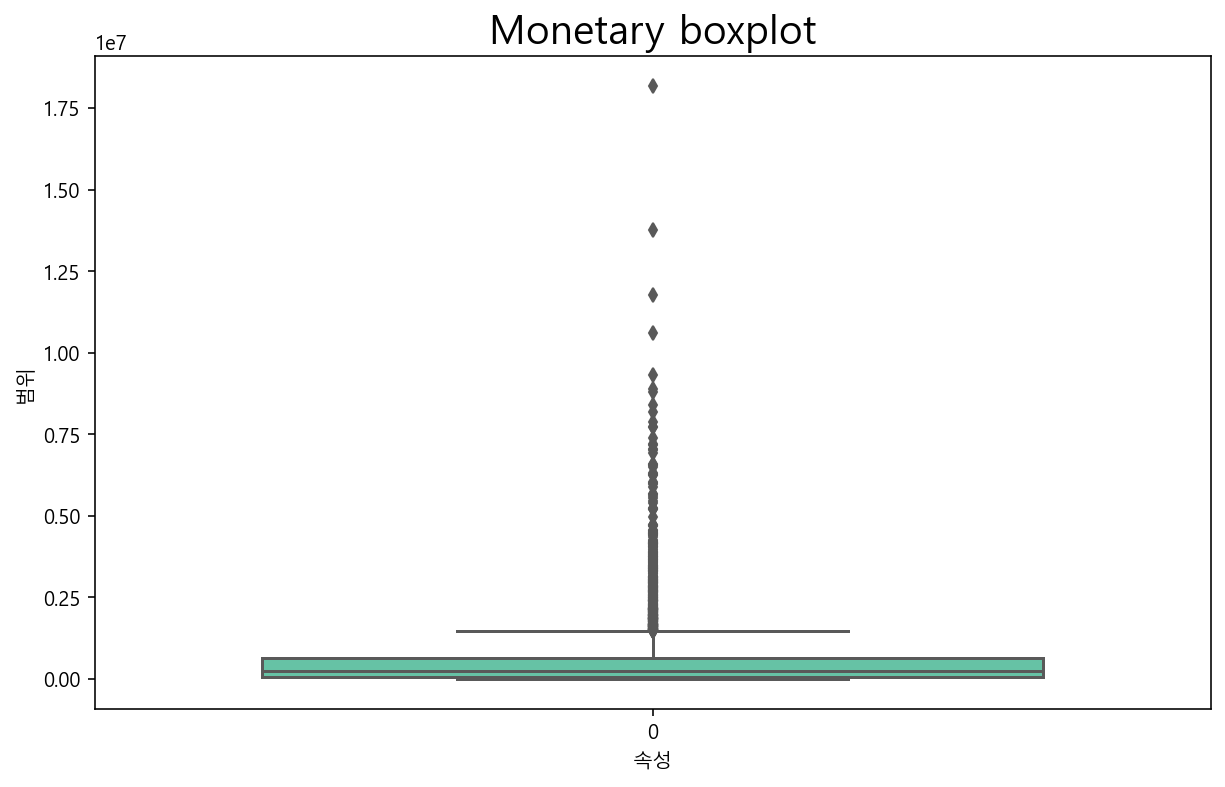

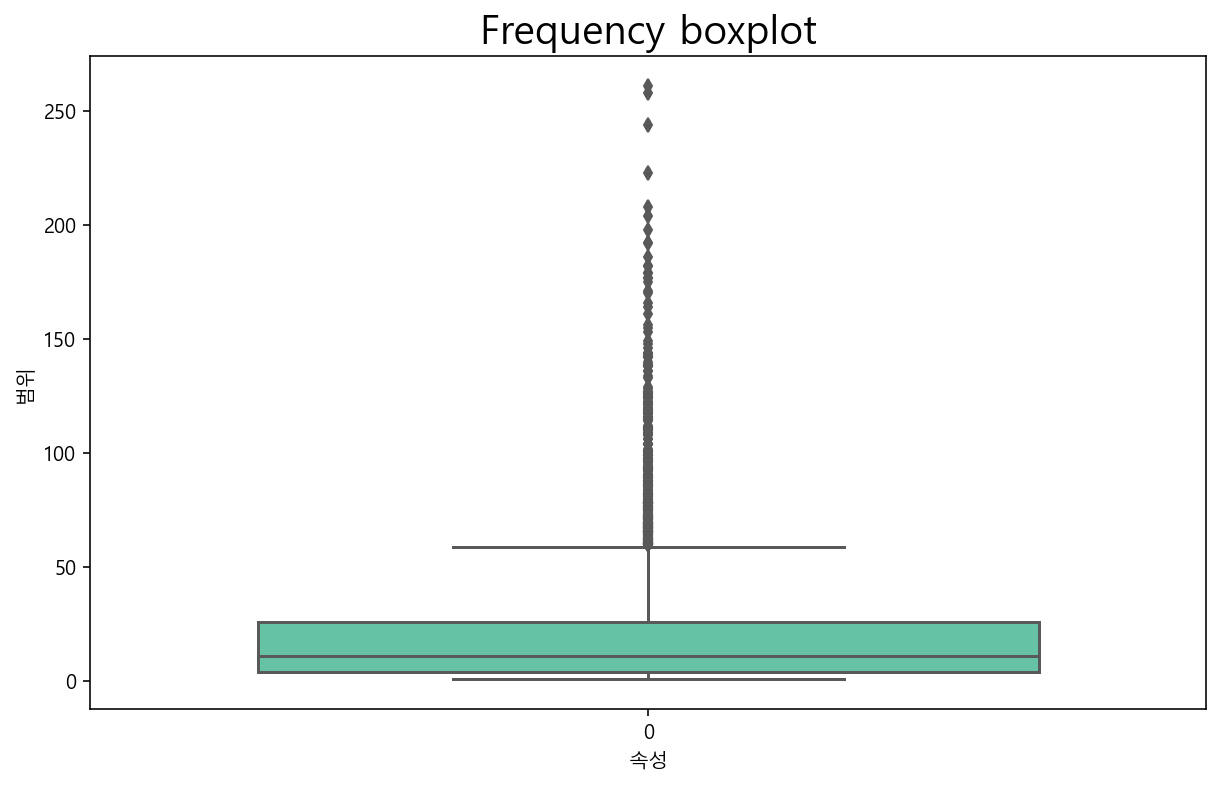

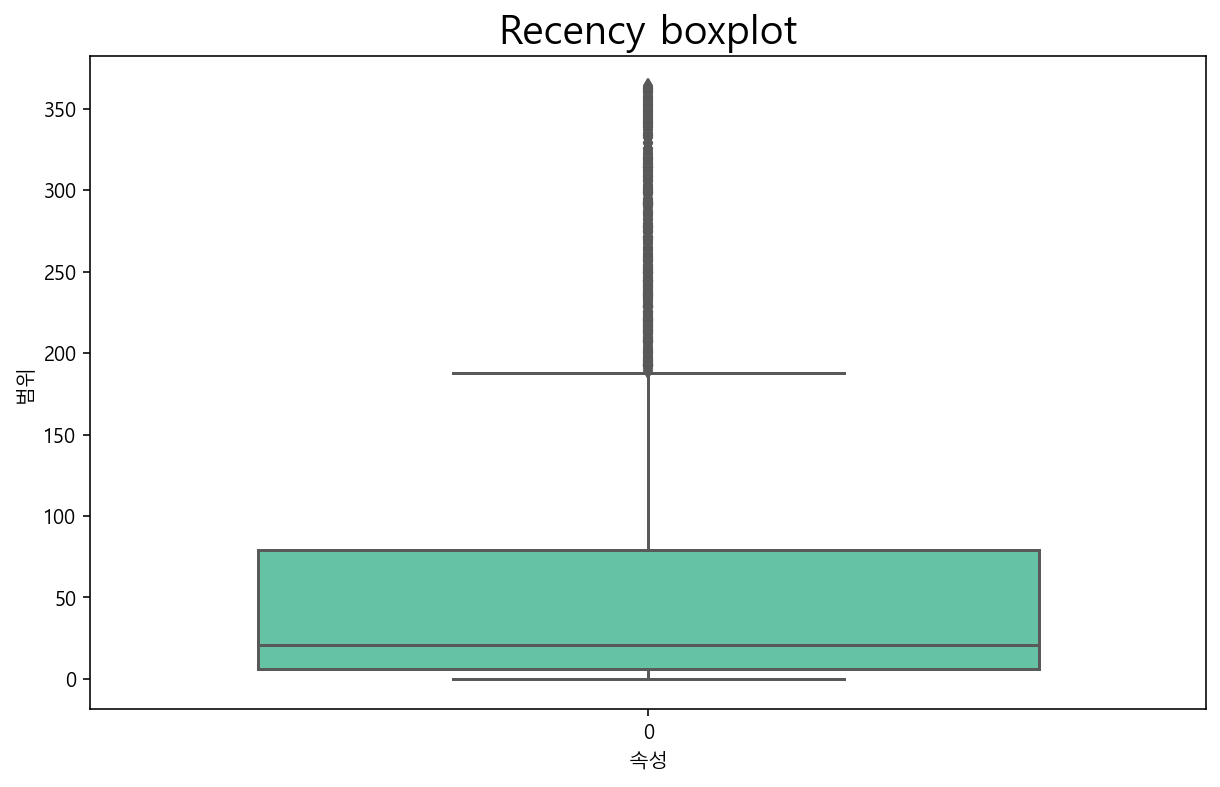

In [14]:
# boxplot으로 각각의 이상치 탐색

cols = ['Monetary', 'Frequency', 'Recency']

for col in cols : 
    plt.figure(figsize = (10, 6))
    sns.boxplot(data=rfm[col], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
    plt.title(f'{col} boxplot', fontsize=20)
    plt.xlabel('속성')
    plt.ylabel('범위')

* boxplot을 그려본 결과 Monetary, Frequency의 경우 이상치 처리가 필요해보임

In [15]:
# 이상치 제거를 위해 일반적으로 사용하는 사분위수 기준으로 Q1, Q3의 범위 지정

Q1 = rfm.Monetary.quantile(0.25)
Q3 = rfm.Monetary.quantile(0.75)
IQR = Q3 - Q1


# 해당하는 값의 범위만 rfm에 다시 할당
# 최소값은 문제없으므로 최대값만 범위 다시 지정

rfm = rfm[(rfm.Monetary <= Q3 + 1.5*IQR)] 
rfm = rfm[(rfm.Frequency <= Q3 + 1.5*IQR)]

In [16]:
rfm.describe()

,CustomerID,Monetary,Frequency,Recency
count,5072.000,5072.000,5072.000,5072.000
mean,8594.786,338681.792,14.740,63.018
std,5548.964,344298.110,15.189,82.080
min,1.000,1280.000,1.000,0.000
25%,3823.750,67000.000,3.000,7.000
50%,8025.000,213350.000,10.000,26.000
75%,13045.000,513617.500,21.000,87.000
max,19953.000,1470640.000,117.000,364.000


In [17]:
# 최종 RFM

rfm.shape

(5072, 4)

---

# RFM DF CSV 파일 저장

In [19]:
rfm.to_csv('고객rfm.csv', index=False)